# ReLU in 1-layer model with NLGP dataset

1. Confirming effect of gain parameter on localization is same with ReLU \& sigmoid activations
   1. It is: we go from localization to long-range oscillations in both cases (which converges to flat, I think?)
2. What happens if we make $K=1$, as we'd like to do when analyzing ReLU dynamics?

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=10000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=20,
)

## ReLU Analysis

### Confirming qualitative results are consistent

#### K = 40

In [2]:
# high gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=1000, gain=3,
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


We see Mexican hats/Gabors!

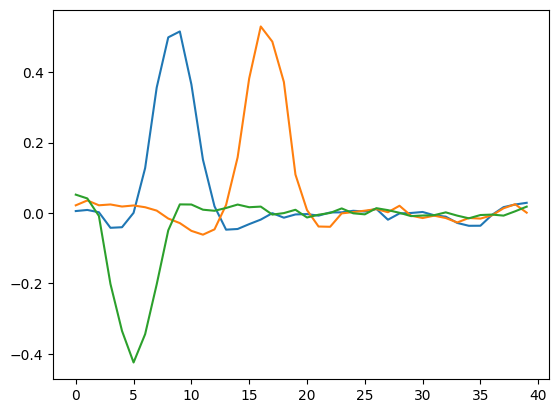

In [3]:
# plot the first three RFs
_ = plt.plot(weights[-1][:3].T)

In [25]:
# low gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=20000, gain=0.01,
    batch_size=1000, evaluation_interval=1000,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights[::2], num_cols=11, evaluation_interval=2000, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Already simulated


Here, we see long-range oscillations instead.
Does this happen in the sigmoid case too?

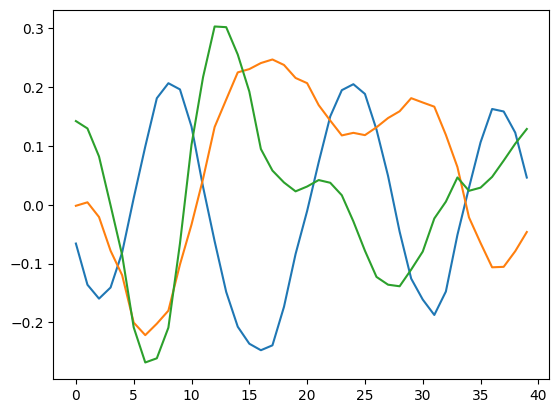

In [7]:
# plot the first three RFs
_ = plt.plot(weights[-1][:3].T)

Already simulated


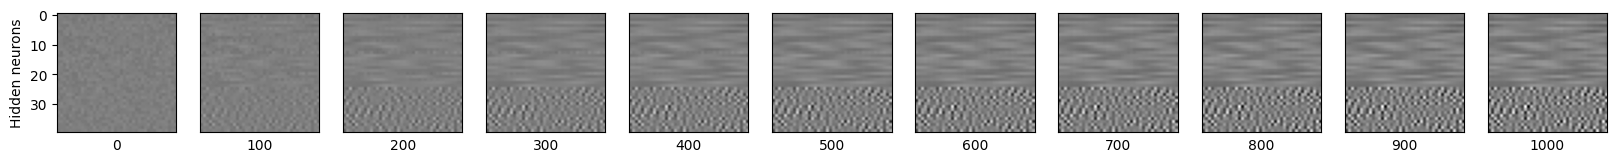

In [26]:
# low gain
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=50., num_epochs=1000, gain=0.01, activation='sigmoid', use_bias=True,
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

We do! The amplitude of the long-range oscillations is just much lower than that of the short-range oscillations, so they appear flat.
But they aren't actually!
So there is still something interesting happening in the Gaussian case.

In [7]:
# plot the first three RFs
_ = plt.plot(weights[-1][:3].T)

#### Gaussian clone (sanity check)

Let's make sure that if we construct a Gaussian to have the same covariance as the NLGP dataset for high gain, it does _not_ yield localization. 

In [28]:
# high gain
config = config_.copy()
config['dataset_cls'] = datasets.NLGPGaussianCloneDataset
config.update(dict(
    num_hiddens=40, learning_rate=5., num_epochs=1000, gain=3,
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 1000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nlgp_gaussian_clone.NLGPGaussianCloneDataset'>,
 'evaluation_interval': 100,
 'gain': 3,
 'init_fn': <function xavier_normal_init at 0x1550ef9c0>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 5.0,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 40,
 'optimizer_fn': <function sgd at 0x151e6d9e0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 1000000
Length of eval dataset: 1000
Length of train sampler: 1000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[40,40],
    bias=None,
    in_features=40,
    out_features=40,
    use_bias=False
  ),
  act=<w

KeyboardInterrupt: 

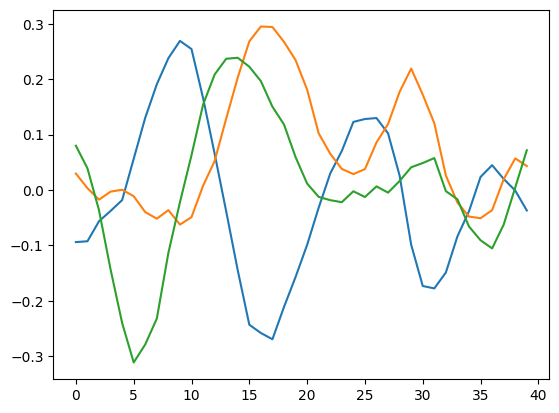

In [14]:
# plot the first three RFs
_ = plt.plot(weights[-1][:3].T)

Good! This is consistent with Alessandro's paper.

#### K = 1

Are the results above consistent if we have just one hidden neuron?

Already simulated


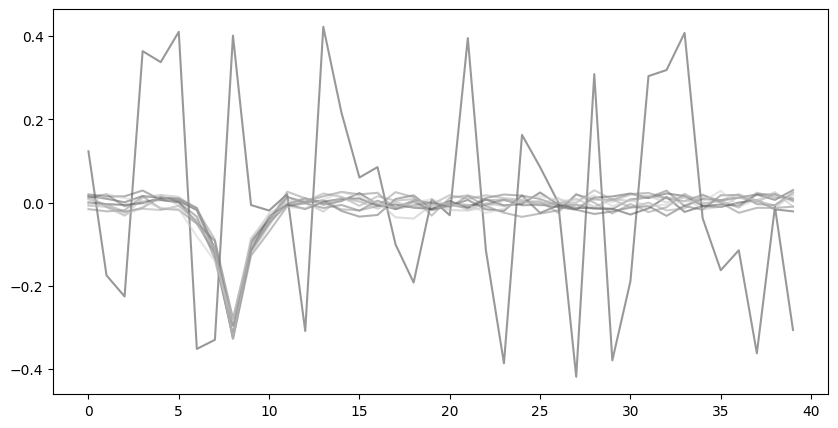

In [29]:
# high gain
config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.5, num_epochs=1000, gain=3,
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))

We still get a bump!
Do we still get a long-range oscillation if we try low gain?

Already simulated


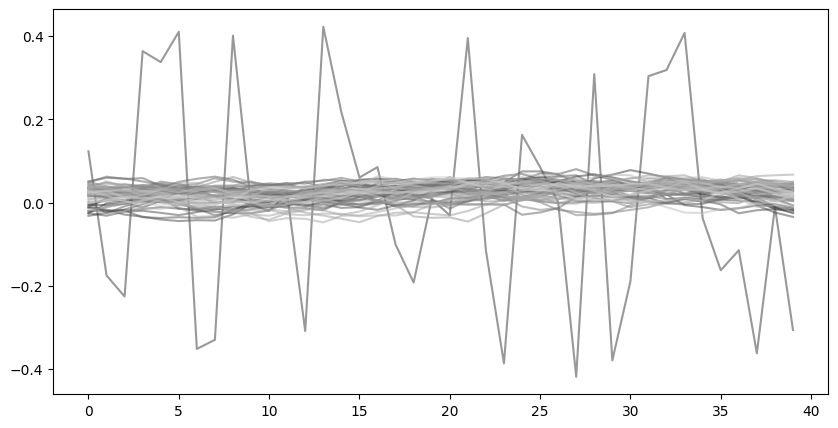

In [30]:
# low gain
config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=5000, gain=0.01, # lower learning seems to be important here, so I bump up the number of epochs
    batch_size=1000, evaluation_interval=100,
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))

It's a bit hard to see...

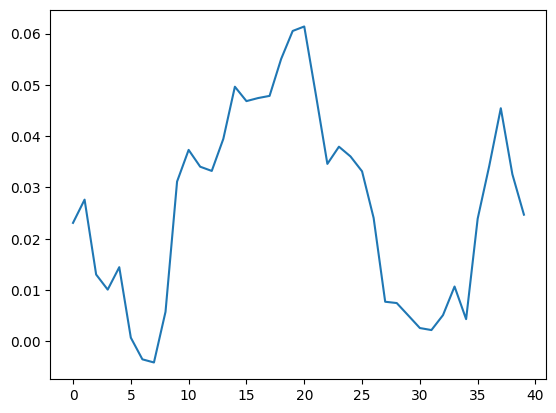

In [31]:
_ = plt.plot(weights[-1][0])

Looks like a long-range oscillation to me!

If we swap the class labels, do we get short-range oscillations?

In [32]:
# low gain, swapped labels
config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=20000, gain=0.01, # lower learning seems to be important here, so I bump up the number of epochs
    batch_size=1000, evaluation_interval=1000, xi1=config_['xi2'], xi2=config_['xi1'],
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))

Already simulated


In [7]:
plt.plot( weights[-1].T )

We do!

Now, let's try to analyze this.

### Discrete Fourier Transform

First, we need to introduce the discrete Fourier transform (DFT).

In [33]:
# discrete Fourier transform
n = config_['num_dimensions']
DFT = np.zeros((n, n), dtype=complex)
w = np.exp(-2 * np.pi * 1j / n)
for i in range(DFT.shape[0]):
    DFT[:, i] = w ** (i * np.arange(n))
DFT /= np.sqrt(n)

Let's start by visualizing the DFT

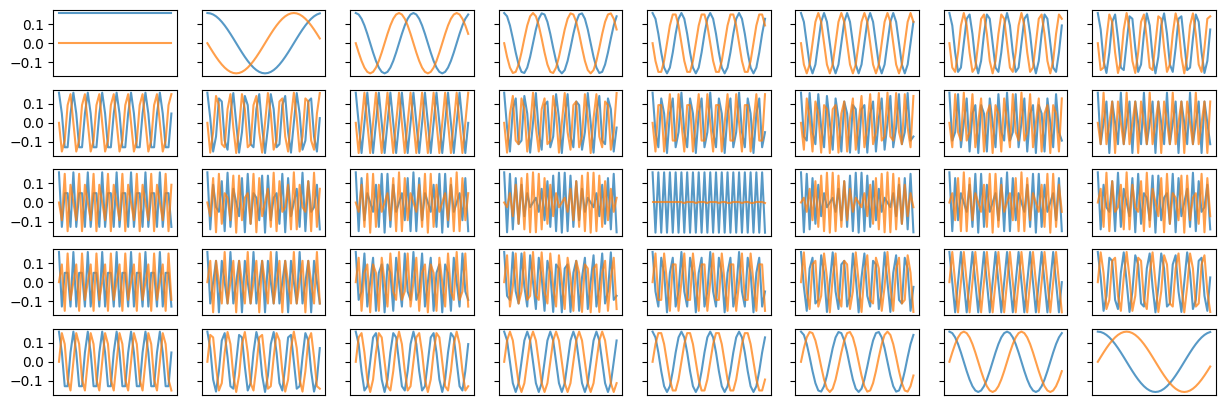

In [34]:
fig, axs = plt.subplots(5, 8, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(DFT.real[:, i], label='real', alpha=0.75)
    ax.plot(DFT.imag[:, i], label='imag', alpha=0.75)
    ax.set_xticks([])

In [35]:
DCT = DFT.real
DST = DFT.imag

DRT_ = np.sqrt(2) * np.concatenate((DCT[:, :(n//2+1)], DST[:, 1:(n//2)]), axis=1)
DRT_[:,0] /= np.sqrt(2)
DRT_[:,n//2] /= np.sqrt(2)
DRT = np.zeros((n, n))
DRT[:,0] = DRT_[:,0]
DRT[:,1::2] = DRT_[:,1:n//2+1]
DRT[:,2::2] = DRT_[:,n//2+1:]

# check that it forms an orthonormal basis for R^n
print( np.linalg.norm(DRT.T @ DRT - np.eye(n)) )

# DFT = np.matrix(DFT)

1.397525836506499e-13


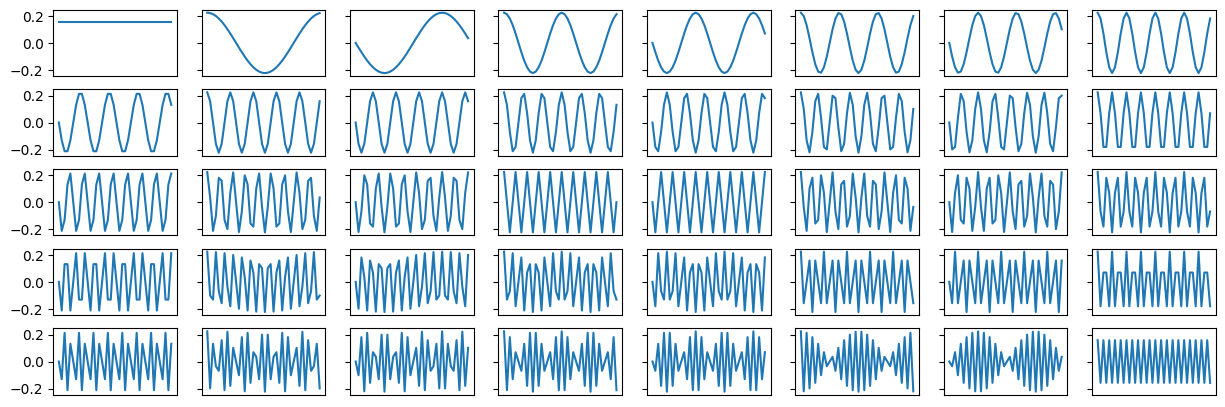

In [36]:
fig, axs = plt.subplots(5, 8, figsize=(15, 5), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(DRT[:, i])
    ax.set_xticks([])

In [37]:
# check that it diagonalizes the covariance matrix
xi1 = config['xi1']
print('xi1 =', xi1)
Sigma = build_gaussian_covariance(n, xi1)
Lambda = np.diag(DRT.T @ Sigma @ DRT)
# it does!
print( np.linalg.norm(Sigma - DRT @ np.diag(Lambda) @ DRT.T) )

xi1 = 1
1.6398162497078138e-13


### Single Neuron

Now that we understand how to use the discrete Fourier transform, let's return to the single neuron analysis.

We will visualize the evolution of its weights in both real (position) space and frequency space.

#### Empirical

Already simulated


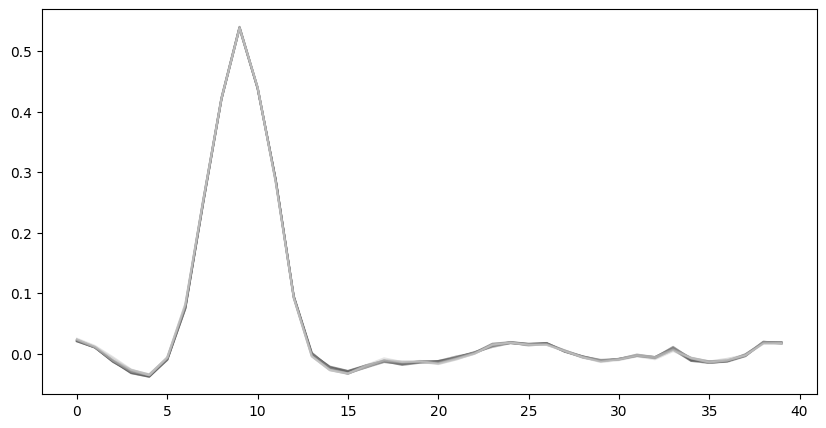

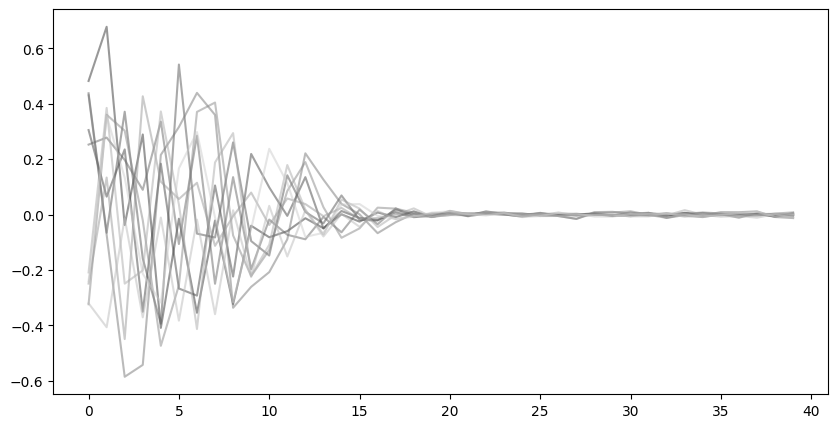

In [198]:
# config = config_.copy()
# config['num_hiddens'] = 1
# config['learning_rate'] = 0.1
# config['num_epochs'] = 20000
# config['use_bias'] = False
# config['init_scale'] = 1.0
# config['gain'] = 0.01
# config['seed'] = 0
# config['xi1'] = 1
# config['xi2'] = 2
# low gain, swapped labels
# config = config_.copy()
# config.update(dict(
#     num_hiddens=1, learning_rate=0.2, num_epochs=50000, gain=0.01, # lower learning seems to be important here, so I bump up the number of epochs
#     batch_size=1000, evaluation_interval=1000, xi1=config_['xi2'], xi2=config_['xi1'],
#     init_scale=1.#0.01,
# ))
config = config_.copy()
config.update(dict(
    num_hiddens=40, learning_rate=1.0, num_epochs=5000, gain=3, # lower learning seems to be important here, so I bump up the number of epochs
    batch_size=1000, evaluation_interval=1000, xi1=config_['xi1'], xi2=config_['xi2'],
    init_scale=1.#0.01,
))

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights[-10:], num_cols=1, num_rows=1, figsize=(10, 5))
# fig.savefig('../thoughts/towards_gdln/figs/math/long_range_experiment.png', dpi=300)
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_[-10:], num_cols=1, num_rows=1, figsize=(10, 5))

We see that the Fourier coefficients are nonzero for just two terms.
The first corresponds to a flat signal, while the second is a sinusoid with a frequency of 1 Hz.

#### Theory

Can we explain the previous result?
Why does Gaussian data converge to a long-range oscillation?

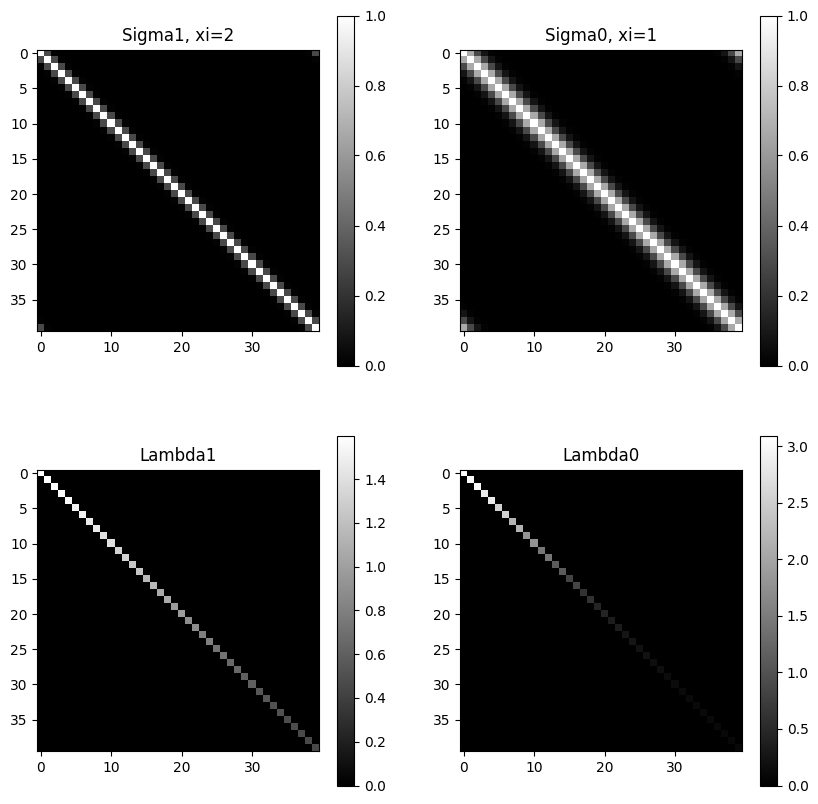

In [199]:
# visualize the covariance matrices driving the dynamics
from localization.utils import build_non_gaussian_covariance
# Sigma1 = build_gaussian_covariance(n, config['xi1'])
# Sigma0 = build_gaussian_covariance(n, config['xi2'])
Sigma1 = build_non_gaussian_covariance(n, config['xi2'], config['gain'])
Sigma0 = build_non_gaussian_covariance(n, config['xi1'], config['gain'])
Lambda1, Lambda0 = DRT.T @ Sigma1 @ DRT, DRT.T @ Sigma0 @ DRT
Lambda1, Lambda0 = np.diag(Lambda1), np.diag(Lambda0)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
im = axs[0,0].imshow(Sigma1, cmap='gray')
axs[0,0].set_title('Sigma1, xi=' + str(config['xi1']))
_ = plt.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(Sigma0, cmap='gray')
axs[0,1].set_title('Sigma0, xi=' + str(config['xi2']))
_ = plt.colorbar(im, ax=axs[0,1])

im = axs[1,0].imshow(np.diag(Lambda1), cmap='gray')
axs[1,0].set_title('Lambda1')
_ = plt.colorbar(im, ax=axs[1,0])

im = axs[1,1].imshow(np.diag(Lambda0), cmap='gray')
axs[1,1].set_title('Lambda0')
_ = plt.colorbar(im, ax=axs[1,1])

In [201]:
num_steps = config['num_epochs']
u1 = np.zeros((num_steps, n))
diag = np.zeros((num_steps, n))
from tqdm import tqdm

u1[0] = DRT.T @ weights[0][0]
lr = config['learning_rate']
for t in tqdm(range(1, num_steps)):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_ * Lambda0 * u1_ ).sum()
    diag[t] = Lambda1 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda0
    step = -0.25 * diag[t] * u1_
    u1[t] = 0.05 * lr * step + u1_ # 4.7
# in Fourier space
# fig, axs = plot_rf_evolution(u1.reshape(-1, 1, n)[::1000], num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(u1_.real.reshape(-1, 1, n)[-10:], num_cols=1, num_rows=1, figsize=(10, 5))

100%|██████████| 4999/4999 [00:00<00:00, 62277.09it/s]


In [202]:
plt.plot( u1_[-1] )
plt.plot( weights[-1,0] )

In [196]:
# u1_OSC = u1_
# weights_OSC = weights

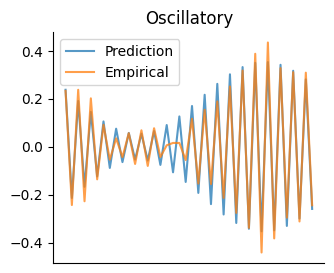

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
ax.plot( u1_OSC[-1], label='Prediction', alpha=0.75)
ax.plot( weights_OSC[-1,0], label='Empirical', alpha=0.75)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Oscillatory')
ax.legend()
fig.savefig('loc_fig_osc.png', dpi=300, bbox_inches='tight')

In [203]:
# u1_LOC = u1_
# weights_LOC = weights

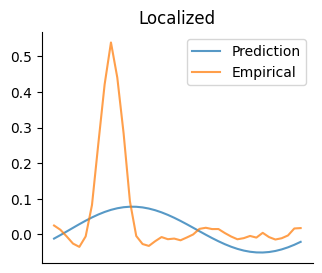

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
ax.plot( u1_LOC[-1], label='Prediction', alpha=0.75)
ax.plot( weights_LOC[-1,0], label='Empirical', alpha=0.75)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Localized')
ax.legend()
fig.savefig('loc_fig_loc.png', dpi=300, bbox_inches='tight')

In [157]:
np.linalg.norm(weights[-1,0] - u1_[-1]) / np.linalg.norm(weights[-1,0])

0.22841522658615174

We see that long-range oscillations dominate more over smaller ones for $\xi_1$ than $\xi_2$.
Moreover, the weights for long-range oscillations are greater for $\xi_1$ than $\xi_2$, while the reverse is true for short-range oscillations.
This may help us explain why setting $Y=1$ to correspond to $\xi_1$ yields long-range oscillations, while we get short-range oscillations when $Y=1$ corresponds to $\xi_2$.

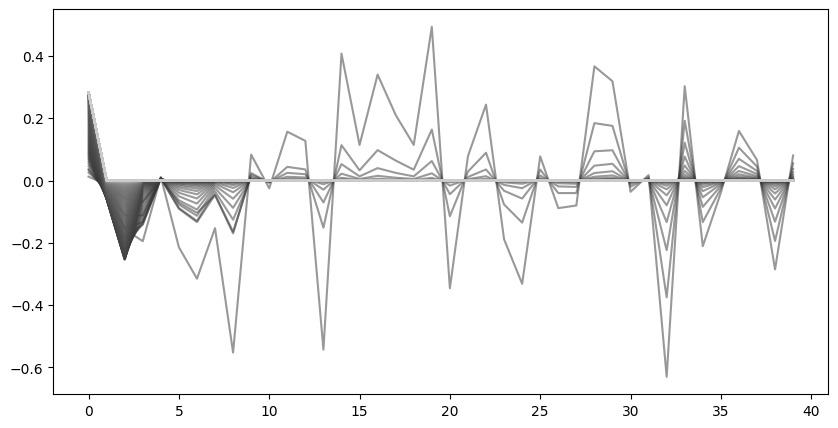

In [74]:
num_steps = config['num_epochs']
u1 = np.zeros((num_steps, n))
diag = np.zeros((num_steps, n))

u1[0] = DRT.T @ weights[0][0]
lr = config['learning_rate']
for t in range(1, num_steps):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_ * Lambda1 * u1_ ).sum()
    diag[t] = Lambda0 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda1
    step = -0.25 * diag[t] * u1_
    u1[t] = 0.5 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1[::100].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
w1 = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(w1[::100].reshape(-1, 1, n), num_cols=1, num_rows=1, figsize=(10, 5))
fig.savefig('../thoughts/towards_gdln/figs/math/long_range_theory.png', dpi=300)

In [45]:
diag[t]

array([-3.86357613e-14,  3.23246635e-02,  3.23246635e-02,  1.23487436e-01,
        1.23487436e-01,  2.57497293e-01,  2.57497293e-01,  4.12036601e-01,
        4.12036601e-01,  5.63496755e-01,  5.63496755e-01,  6.91705410e-01,
        6.91705410e-01,  7.83141937e-01,  7.83141937e-01,  8.32092572e-01,
        8.32092572e-01,  8.39910053e-01,  8.39910053e-01,  8.13040472e-01,
        8.13040472e-01,  7.60637281e-01,  7.60637281e-01,  6.92439483e-01,
        6.92439483e-01,  6.17291024e-01,  6.17291024e-01,  5.42375514e-01,
        5.42375514e-01,  4.73034170e-01,  4.73034170e-01,  4.12951456e-01,
        4.12951456e-01,  3.64504611e-01,  3.64504611e-01,  3.29132495e-01,
        3.29132495e-01,  3.07644867e-01,  3.07644867e-01,  3.00442430e-01])

In [43]:
Lambda0 + Lambda1

array([5.3175447 , 5.22026966, 5.22026966, 4.94127895, 4.94127895,
       4.51611905, 4.51611905, 3.99513357, 3.99513357, 3.4330645 ,
       3.4330645 , 2.87917906, 2.87917906, 2.37036369, 2.37036369,
       1.92832038, 1.92832038, 1.56057344, 1.56057344, 1.26399479,
       1.26399479, 1.02923425, 1.02923425, 0.84471785, 0.84471785,
       0.69946687, 0.69946687, 0.58458608, 0.58458608, 0.49367295,
       0.49367295, 0.42255954, 0.42255954, 0.36877064, 0.36877064,
       0.33096112, 0.33096112, 0.30846496, 0.30846496, 0.30099263])

In [53]:
# Lambda1 * np.sqrt(2/np.pi) / np.sqrt(np.sum(u1_ * Lambda1 * u1_))
np.sqrt(2/np.pi) / np.sqrt(np.sum(u1_ * Lambda1 * u1_))

1.5000517345542557

In [52]:
Lambda0 / Lambda1 + 1

array([  1.50005173,   1.50939815,   1.50939815,   1.53850038,
         1.53850038,   1.59075227,   1.59075227,   1.6725495 ,
         1.6725495 ,   1.79461676,   1.79461676,   1.97438609,
         1.97438609,   2.24018362,   2.24018362,   2.63866717,
         2.63866717,   3.24831389,   3.24831389,   4.20454468,
         4.20454468,   5.74803444,   5.74803444,   8.3210802 ,
         8.3210802 ,  12.76818623,  12.76818623,  20.77464033,
        20.77464033,  35.8807571 ,  35.8807571 ,  65.97167488,
        65.97167488, 129.66992799, 129.66992799, 271.49272737,
       271.49272737, 564.2172032 , 564.2172032 , 820.61649915])

In [56]:
plt.plot( u1[:,2] )

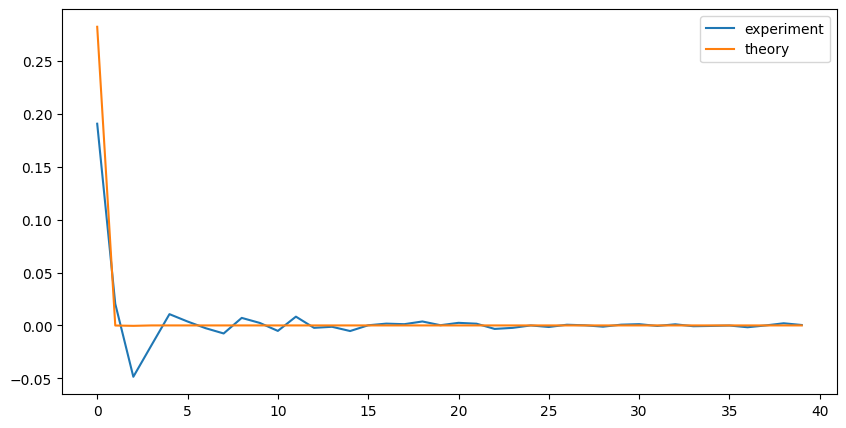

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ = ax.plot(weights_[-1][0], label='experiment')
_ = ax.plot(u1[-1], label='theory')
_ = ax.legend()
fig.savefig('../thoughts/towards_gdln/figs/math/theory_vs_experiment.png', dpi=300)

Looks pretty sexy to me!

Can we also explain why we get short-range oscillations when we flip the class label?
This amounts to swapping $\Lambda_1$ and $\Lambda_0$ in the ODE equation.

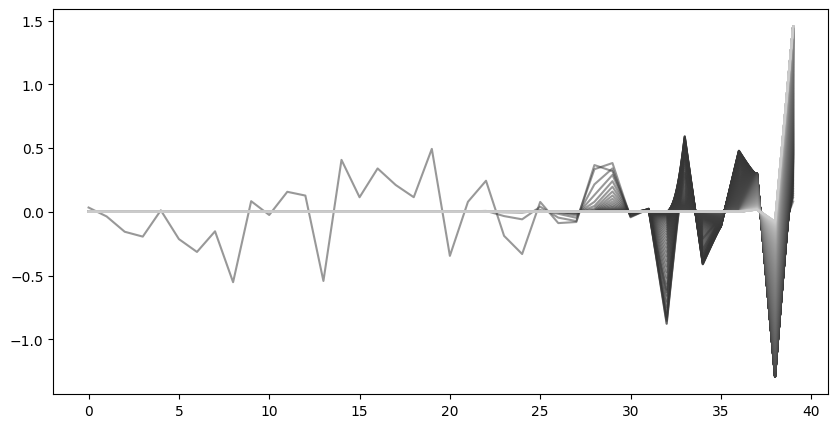

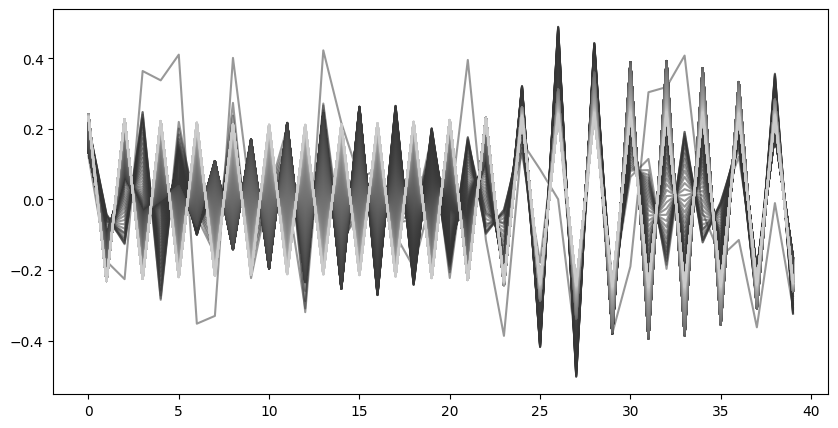

In [24]:
num_steps = 500 * config['num_epochs']
u1 = np.zeros((num_steps, n))
diag = np.zeros((num_steps, n))

u1[0] = DRT.T @ weights[0][0]
lr = config['learning_rate']
for t in range(1, num_steps):
    u1_ = u1[t-1]
    # norm_ = np.asarray(u1_.T @ Lambda1 @ u1_)[0][0]
    norm_ = ( u1_.conj() * Lambda0 * u1_ ).sum()
    diag[t] = Lambda1 + ( 1 - np.sqrt(2/np.pi) * (1 / np.sqrt(norm_)) ) * Lambda0
    step = -0.25 * diag[t] * u1_
    u1[t] = 10 * lr * step + u1_
# in Fourier space
fig, axs = plot_rf_evolution(u1.reshape(-1, 1, n)[::1000], num_cols=1, num_rows=1, figsize=(10, 5))
# in real space
u1_ = np.asarray(np.inner(u1, DRT))
fig, axs = plot_rf_evolution(u1_.real.reshape(-1, 1, n)[::1000], num_cols=1, num_rows=1, figsize=(10, 5))

Let's goooooooo!

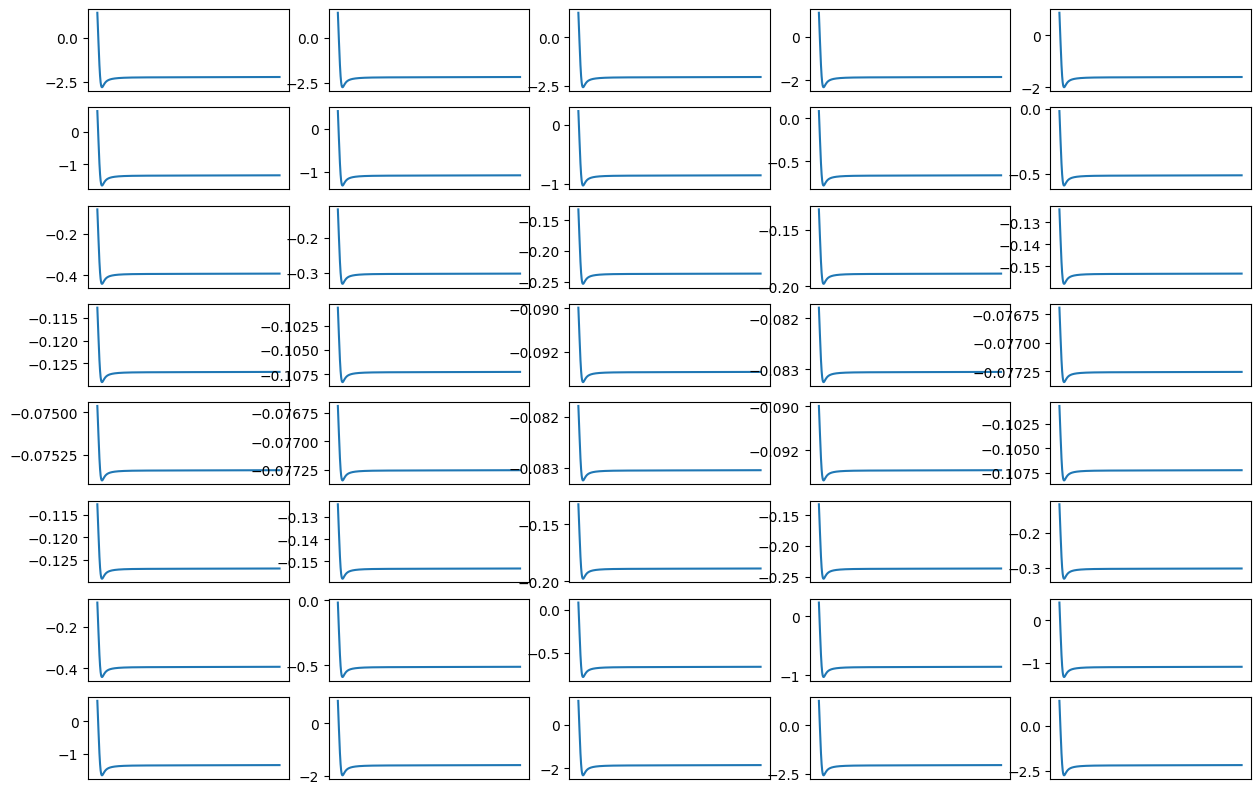

In [373]:
# fig, axs = plt.subplots(8, 5, figsize=(15, 10), sharey=True)
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(diag[:, i])
#     ax.set_xticks([])

s = 1 - np.sqrt(2/np.pi) / np.sqrt(np.sum(np.square(u1) * Lambda1, axis=1))
d = -0.25 * Lambda0.reshape(1, -1) + (s.reshape(-1, 1) * Lambda1.reshape(1, -1))
fig, axs = plt.subplots(8, 5, figsize=(15, 10))#, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(d[:, i])
    ax.set_xticks([])

#### Empirically, what happens with higher gain?

Already simulated


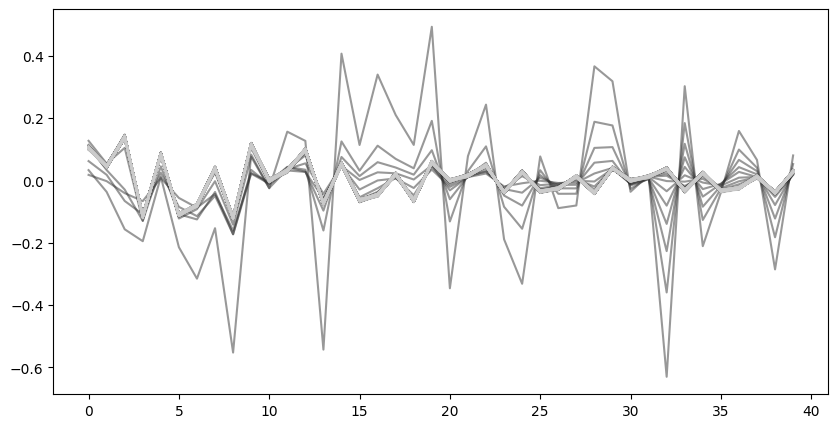

In [29]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.1 # 0.01
config['num_epochs'] = 20000 # 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

#### What if we use Gaussian data with the same covariance?

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 10000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nlgp_gaussian_control.NLGPGaussianControlDataset'>,
 'evaluation_interval': 20,
 'gain': 3.0,
 'init_fn': <function xavier_normal_init at 0x1568a5da0>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 0.01,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 2000,
 'num_hiddens': 1,
 'optimizer_fn': <function sgd at 0x153540180>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 20000000
Length of eval dataset: 1000
Length of train sampler: 20000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[1,40],
    bias=None,
    in_features=40,
    out_features=1,
    use_bias=False
  ),
  

NameError: name 'DRT' is not defined

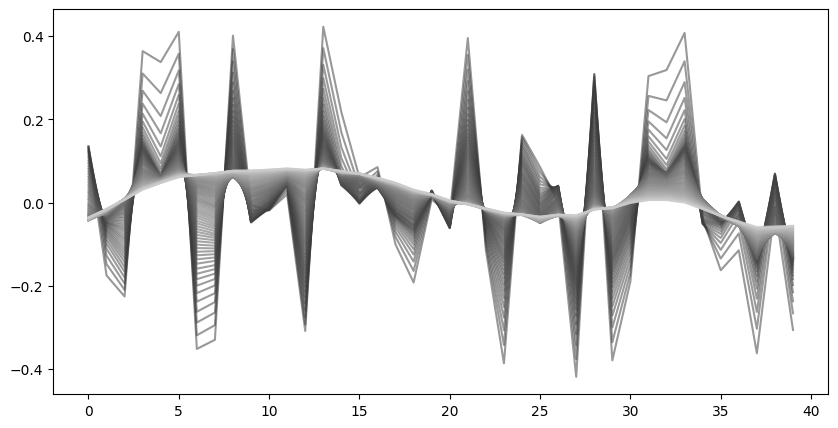

In [2]:
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
config['init_scale'] = 1.0
config['gain'] = 3.
config['dataset_cls'] = datasets.NLGPGaussianControlDataset

weights, metrics = simulate_or_load(**config)
# in real space
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1, figsize=(10, 5))
# in Fourier space
weights_ = np.asarray(np.inner(weights, DRT.T)).reshape(-1, 1, n)
fig, axs = plot_rf_evolution(weights_, num_cols=1, num_rows=1, figsize=(10, 5))

### Multiple neurons

Empirically, what happens to the order parameter
$$
    \gamma = \frac{ w_i^\top \Sigma w_j }{ \sqrt{ (w_i^\top \Sigma w_i) (w_j^\top \Sigma w_j) } }
$$
in both the low and high gain settings?

Simulating
Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 10000,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.nonlinear_gp.NonlinearGPDataset'>,
 'evaluation_interval': 20,
 'gain': 3.0,
 'init_fn': <function xavier_normal_init at 0x14e9f6d40>,
 'init_scale': 1.0,
 'kwargs': {},
 'learning_rate': 0.01,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 2000,
 'num_hiddens': 1,
 'optimizer_fn': <function sgd at 0x14d7b80e0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (-1, 1),
 'use_bias': False,
 'wandb_': False,
 'xi1': 2,
 'xi2': 1}

Length of train dataset: 20000000
Length of eval dataset: 1000
Length of train sampler: 20000000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[1,40],
    bias=None,
    in_features=40,
    out_features=1,
    use_bias=False
  ),
  act=<wrapped func

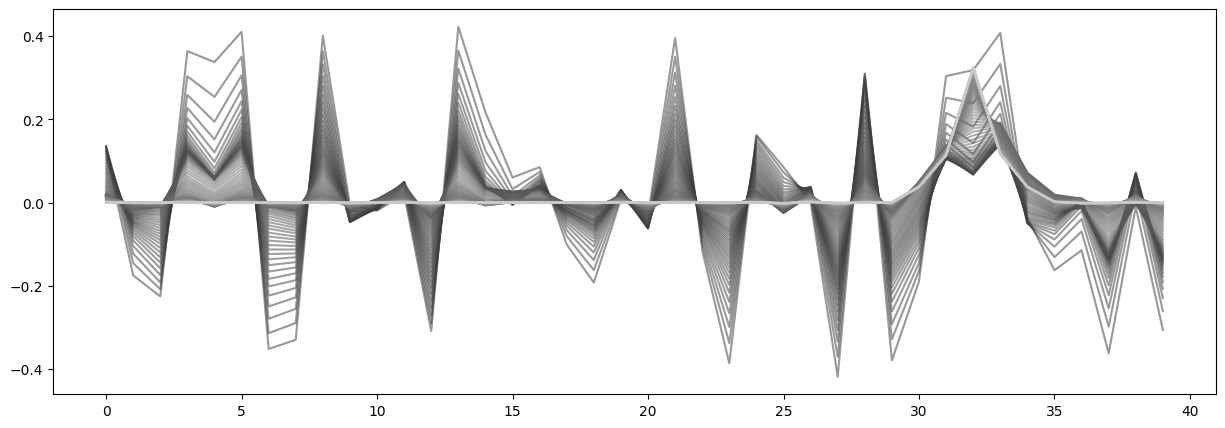

In [28]:
# what if we make w1(0) \propto 1 (+ noise)?
config = config_.copy()
config['num_hiddens'] = 1
config['learning_rate'] = 0.01
config['num_epochs'] = 2000
config['use_bias'] = False
# config['init_fn'] = lambda weight, key, scale: scale * (1. + models.xavier_normal_init(weight, key, 0.1))
config['init_scale'] = 1. #0.01
config['gain'] = 3.

weights, metrics = simulate_or_load(**config)
fig, axs = plot_rf_evolution(weights, num_cols=1, num_rows=1)

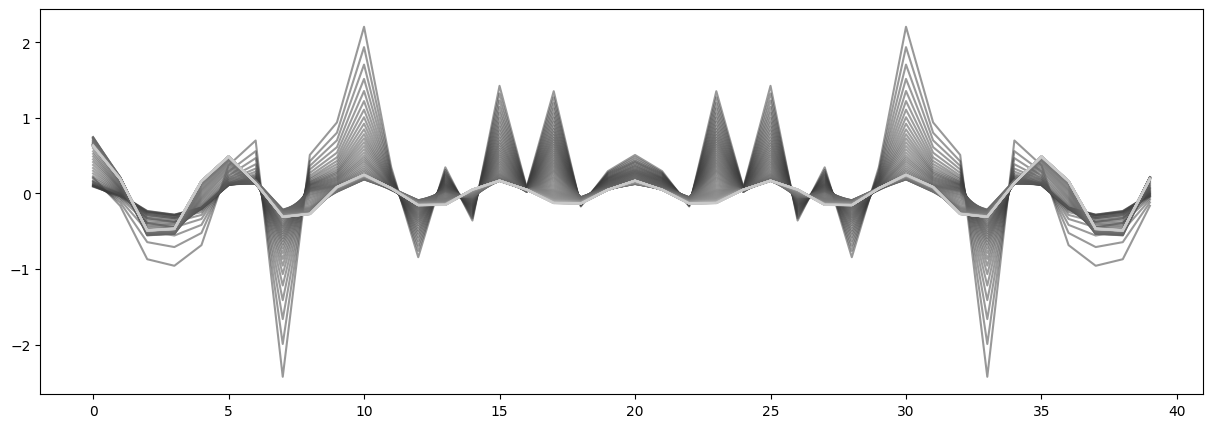

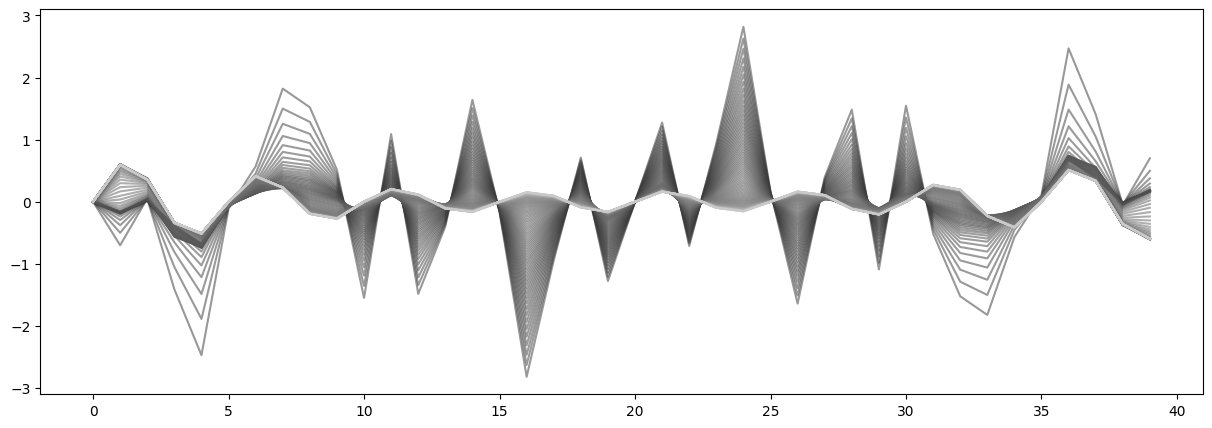

In [65]:
# discrete Fourier transform
F = np.zeros((config['num_dimensions'], config['num_dimensions']), dtype=complex)
w = np.exp(2 * np.pi * 1j / config['num_dimensions'])
for i in range(F.shape[0]):
    F[:, i] = w ** (i * np.arange(F.shape[0]))
weights_ = np.dot(weights, F.real - 1j * F.imag)
fig, axs = plot_rf_evolution(weights_.real, num_cols=1, num_rows=1)
fig, axs = plot_rf_evolution(weights_.imag, num_cols=1, num_rows=1)

### Non-Gaussian Data

As $g$ gets large, $\frac{1}{Z(g)} \text{erf}(g z_i) \to \text{sign}(z_i)$.
So, for $x \in \{ \pm 1 \}^n$,
$$
    \mathbb{P}( X = x )
    = \mathbb{P}( \text{sign}(Z) = x )
    = \mathbb{P}( \forall i: x_i Z_i > 0 ).
$$

In [410]:
L = 14 # config['num_dimensions']
N = 1000000
xi = 3. # config['xi1']
Sigma = build_gaussian_covariance(L, xi)
x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))

/var/folders/gq/3xlhh9496_j9xpjb7tkbqh280000gn/T/ipykernel_94977/1239668083.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  x_ = np.random.multivariate_normal(np.zeros(L), Sigma, size=(N,))


In [413]:
# x = 2 * np.random.randint(0, 2, (N,L)) - 1
x = -np.ones(L)
np.all(np.sign(x_) == x, axis=1).mean()

0.064933

## Block Pulse

Using JAX backend: cpu

Using configuration:
{'activation': 'relu',
 'batch_size': 559,
 'class_proportion': 0.5,
 'dataset_cls': <class 'localization.datasets.block_pulse.BlockDataset'>,
 'evaluation_interval': 100,
 'gain': None,
 'init_fn': <function xavier_normal_init at 0x154181d00>,
 'init_scale': 0.01,
 'kwargs': {},
 'learning_rate': 5.0,
 'model_cls': <class 'localization.models.feedforward.SimpleNet'>,
 'num_dimensions': 40,
 'num_epochs': 1000,
 'num_hiddens': 40,
 'optimizer_fn': <function sgd at 0x150e440e0>,
 'sampler_cls': <class 'localization.samplers.base.EpochSampler'>,
 'save_': True,
 'seed': 0,
 'support': (0, 1),
 'use_bias': True,
 'wandb_': False,
 'xi1': 0.25,
 'xi2': 0.1}

kwargs: {'gain': None}
kwargs: {'gain': None}
Length of train dataset: 559000
Length of eval dataset: 1000
Length of train sampler: 559000
Length of eval sampler: 1000
Model:
SimpleNet(
  fc1=Linear(
    weight=f32[40,40],
    bias=f32[40],
    in_features=40,
    out_features=40,
    use_bi

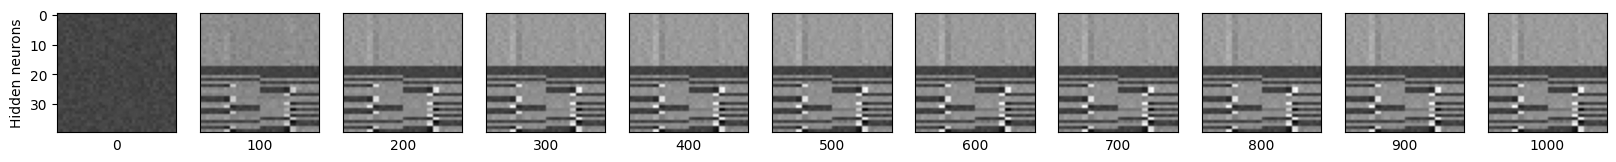

In [4]:
config = config_.copy()
config.update(dict(
    dataset_cls=datasets.BlockDataset, xi1=0.25, xi2=0.1, support=(0, 1),
    num_hiddens=40, learning_rate=5., num_epochs=1000,
    batch_size=559, evaluation_interval=100,
    init_scale=1e-2, # seed=42
    use_bias=True
))

weights, metrics = simulate(**config) # _or_load
fig, axs = plot_receptive_fields(weights, num_cols=11, evaluation_interval=100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

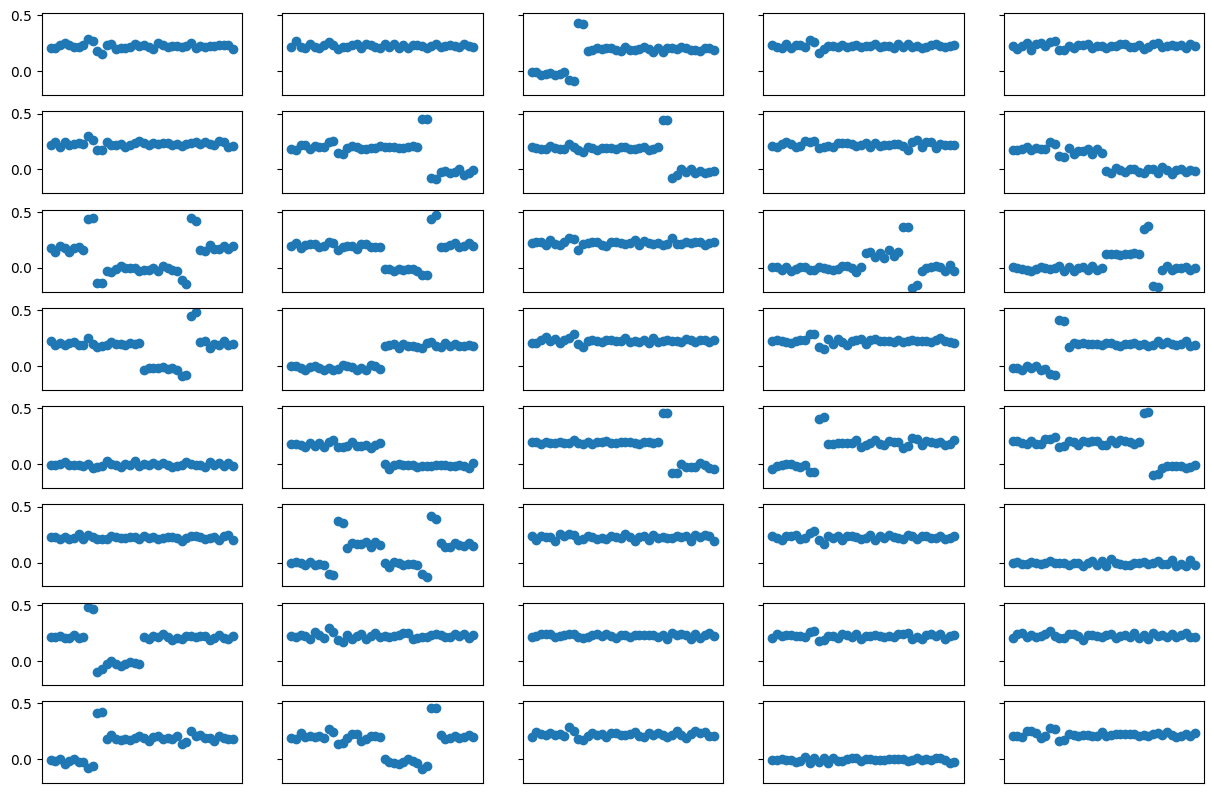

In [5]:
fig, axs = plt.subplots(8, 5, figsize=(15, 10), sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(weights[-1][i], 'o')
    ax.set_xticks([])

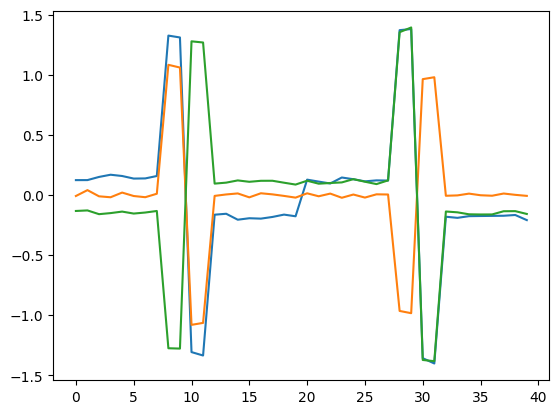

In [11]:
# plot the first three RFs
_ = plt.plot(weights[-1][:3].T)

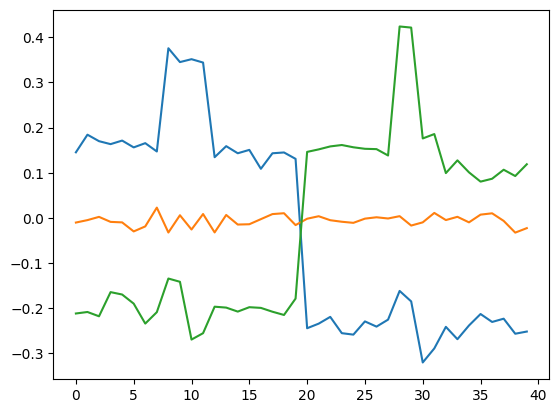

In [17]:
# plot the last three RFs
_ = plt.plot(weights[-1][-3:].T)

## Gated Analysis

In [91]:
config['gain'] = 3. # 0.01
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:10000]
n = config['num_dimensions']

(array([   6.,   62.,  257.,  688., 1021., 1183.,  958.,  524.,  213.,
          30.]),
 array([-4.08358002, -3.34211993, -2.60066009, -1.8592    , -1.11774004,
        -0.37628007,  0.36517993,  1.10663986,  1.84809995,  2.58955979,
         3.33101988]),
 <BarContainer object of 10 artists>)

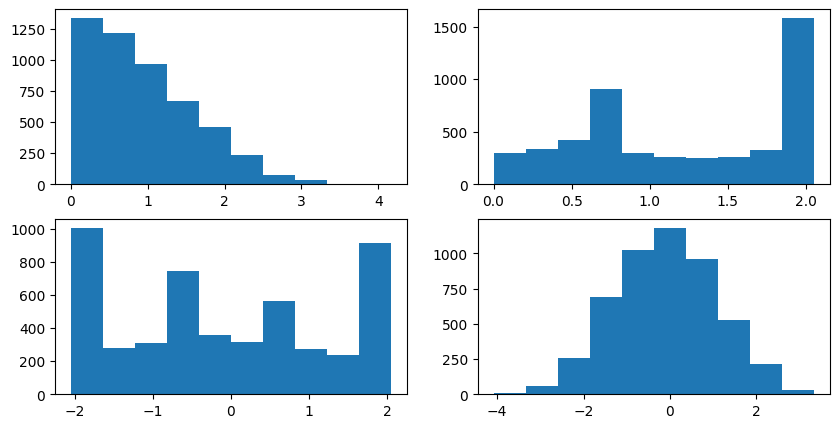

In [100]:
e1 = np.zeros(n)
e1[:3] = 1
e1 /= np.linalg.norm(e1)
a_rand = jax.random.normal(jax.random.PRNGKey(0), (n,))
a_rand /= np.linalg.norm(a_rand)
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].hist( (x @ a_rand)[(x @ a_rand) > 0] )
axs[0,1].hist( (x @ e1)[(x @ e1) > 0] )
axs[1,0].hist( (x @ e1)[(x @ a_rand) > 0] )
axs[1,1].hist( (x @ a_rand)[(x @ e1) > 0] )

Exception ignored in: <function _xla_gc_callback at 0x11d41a0c0>
Traceback (most recent call last):
  File "/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


(array([1.478e+03, 1.363e+03, 9.650e+02, 5.860e+02, 3.290e+02, 1.620e+02,
        5.700e+01, 2.300e+01, 5.000e+00, 1.000e+00]),
 array([2.74268386e-05, 5.62180519e-01, 1.12433362e+00, 1.68648660e+00,
        2.24863982e+00, 2.81079292e+00, 3.37294579e+00, 3.93509889e+00,
        4.49725199e+00, 5.05940533e+00, 5.62155819e+00]),
 <BarContainer object of 10 artists>)

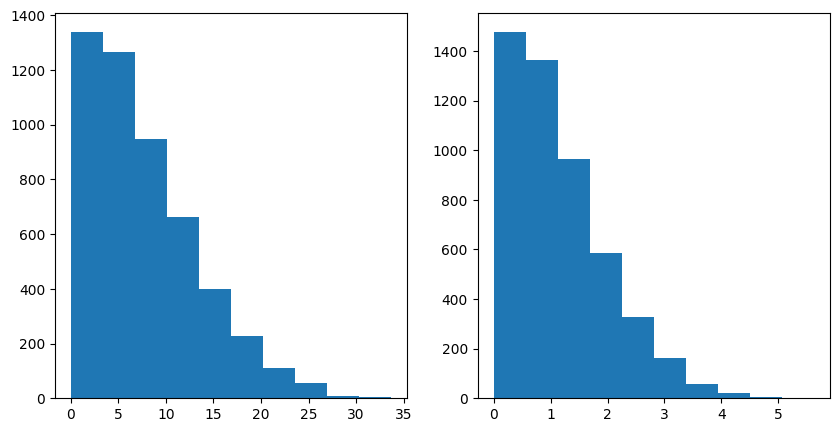

In [90]:
e1 = np.zeros(n)
e1[0] = 1
a_rand = jax.random.normal(jax.random.PRNGKey(0), (n,))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist( (x @ a_rand)[(x @ a_rand) > 0] )
ax2.hist( (x @ e1)[(x @ e1) > 0] )

### Sign-flipping

See script.

### Predicting localization location

### Early dynamics

In [32]:
config['gain'] = 3. # 0.01
dataset = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), **config)
x, y = dataset[:10000]
n = config['num_dimensions']

In [33]:
def viz_A(A):
    A = np.concatenate( np.concatenate(A, axis=2), axis=0 )
    D, P = np.linalg.eigh(A)

    # visualizing A
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    im = ax1.imshow(A, cmap='gray')
    plt.colorbar(im, ax=ax1)
    # im = ax2.imshow(np.diag(D), cmap='gray')
    # plt.colorbar(im, ax=ax2)
    ax2.plot(D)
    im = ax3.imshow(P, cmap='gray')
    plt.colorbar(im, ax=ax3)
    return fig, (ax1, ax2, ax3)

In [34]:
# small bump gate
A_small = np.stack([ [(x * (x[:,i] > 0).reshape(-1,1)).T @ (x * (x[:,j] > 0).reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

# random gate
gates = jax.random.randint(jax.random.PRNGKey(0), (len(x), n), minval=0, maxval=2)
A_rand = np.stack([ [(x * gates[:,i].reshape(-1,1)).T @ (x * gates[:,j].reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

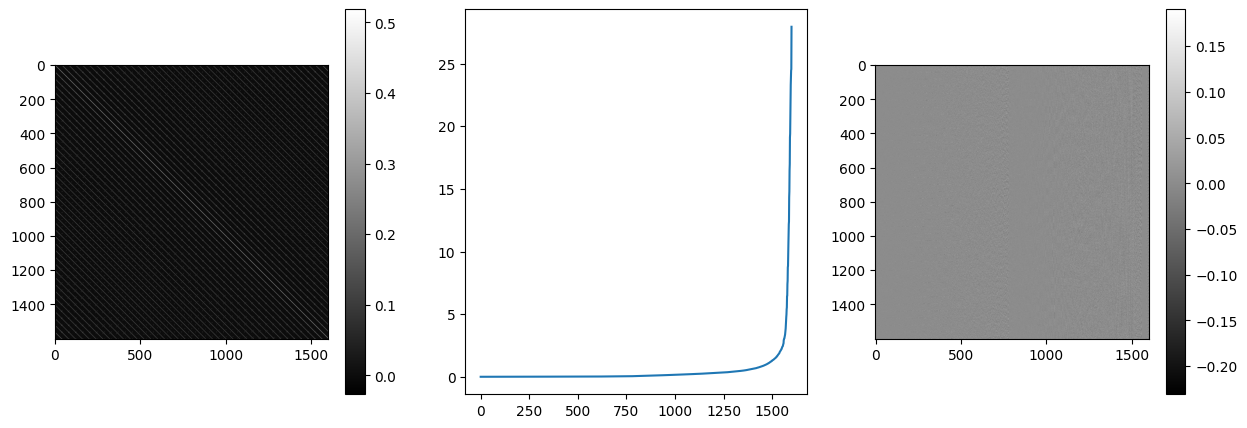

In [35]:
# small bump gate
# sparsely sampled
t = np.arange(40)#[::5]
A_ = A_small[t][:,t]
fig, axs = viz_A(A_)

# # sequentially sampled
# t = np.arange(8)
# A_ = A_small[t][:,t]
# fig, axs = viz_A(A_)

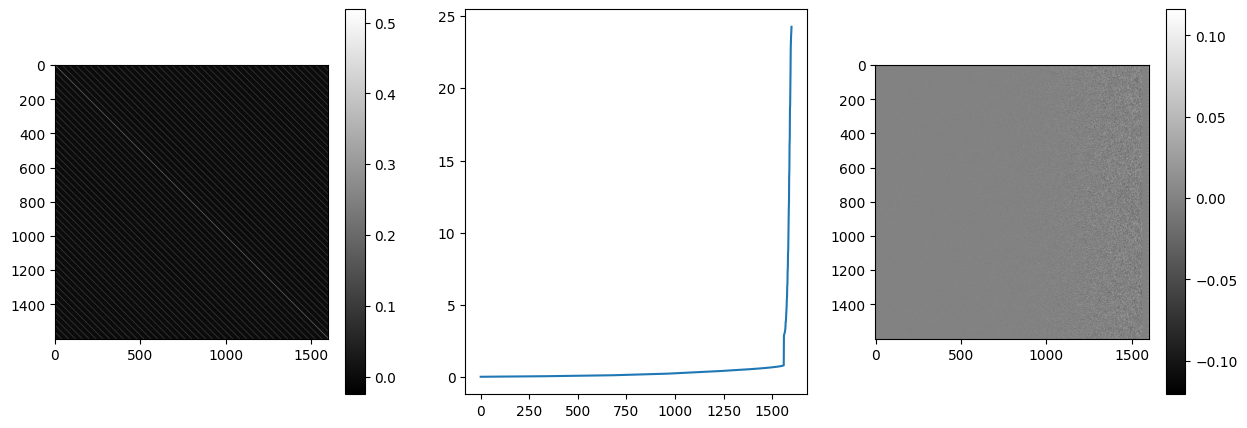

In [36]:
# random gate
# sparsely sampled
t = np.arange(40)#[::5]
A_ = A_rand[t][:,t]
fig, axs = viz_A(A_)

# # sequentially sampled
# t = np.arange(8)
# A_ = A_rand[t][:,t]
# fig, axs = viz_A(A_)

In [ ]:
# all on
gates = jax.random.randint(jax.random.PRNGKey(0), (len(x), n), minval=0, maxval=2)
A_rand = np.stack([ [(x * gates[:,i].reshape(-1,1)).T @ (x * gates[:,j].reshape(-1,1)) / len(x) for i in range(n) ] for j in range(n) ])

### Meta-optimization

### Structure in Limiting Behavior

In [15]:
n = config['num_dimensions']
def sigma_yx(n, xi1, g):
    i = n//2
    r = np.exp( - (np.arange(n) - i) ** 2 / (xi1 ** 2) )
    sigma_yx = (1/np.sqrt(np.pi)) * np.arctan( r / ( 1/(2*(g**2)) + (1 - r**2) ) )
    return sigma_yx

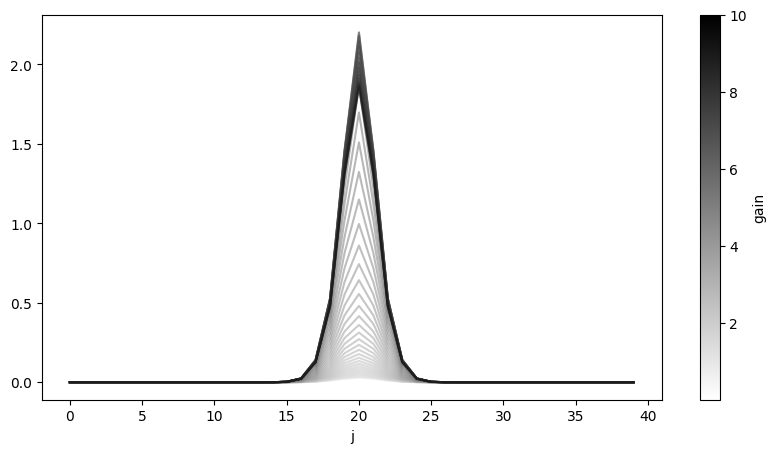

In [33]:
Z = lambda g: np.sqrt( (2/np.pi) * np.arcsin( (g**2) / ( 1 + (g**2) ) ) )
gains = np.logspace(-2, 1, 50)
sigma_yx_ = np.stack([ sigma_yx(n, config['xi1'], g) / Z(g) for g in gains ])
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cmap_ = plt.get_cmap('binary')
color = cmap_(np.linspace(0.1, 0.9, len(gains)))
for t in range(len(gains)):
    p = ax.plot(sigma_yx_[t,:], color=color[t], alpha=0.5)
ax.set_xlabel('j')
# add colorbar to ax
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.Normalize(vmin=gains.min(), vmax=gains.max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
# label colorbar
cbar.set_label('gain')
fig.savefig('../thoughts/towards_gdln/figs/math/sigma_yx.png', dpi=300)

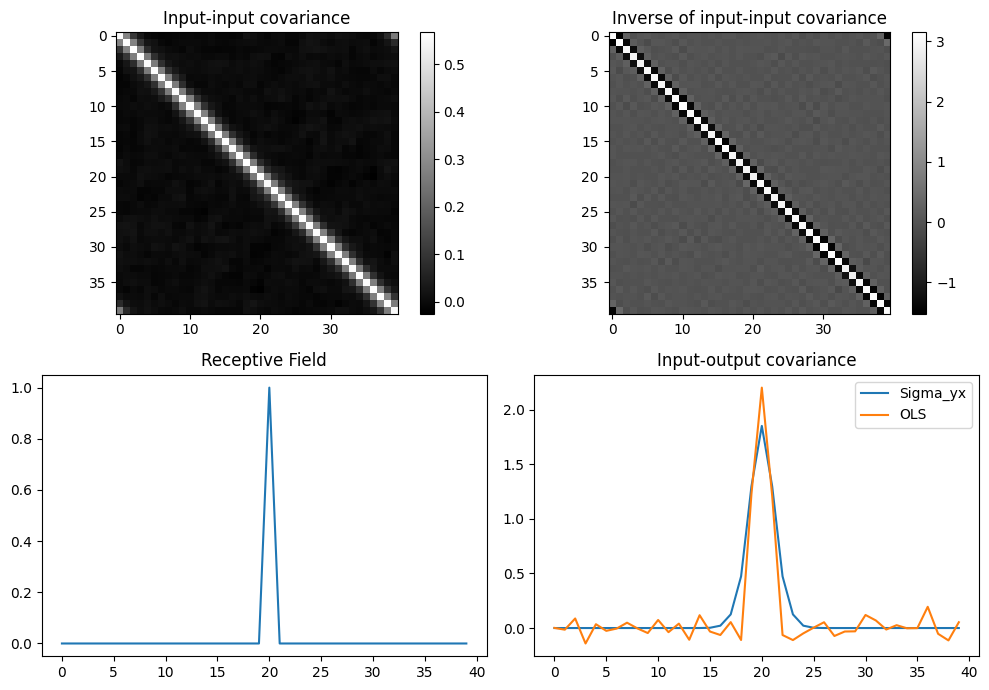

In [105]:
# small bump gate
rf = np.zeros(n); rf[20] = 1.
gate = x @ rf > 0
A = (x[gate].T @ x[gate]) / len(x)
# plot it
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
im = axs[0,0].imshow(A, cmap='gray')
_ = plt.colorbar(im)
axs[0,0].set_title("Input-input covariance")
im = axs[0,1].imshow(np.linalg.inv(A), cmap='gray')
plt.colorbar(im)
axs[0,1].set_title("Inverse of input-input covariance")
axs[1,0].plot(rf)
axs[1,0].set_title("Receptive Field")
axs[1,1].plot(sigma_yx_[-1], label="Sigma_yx")
axs[1,1].plot(np.linalg.inv(A) @ sigma_yx_[-1], label="OLS")
axs[1,1].set_title("Input-output covariance")
axs[1,1].legend()
fig.tight_layout()
fig.savefig('../thoughts/towards_gdln/figs/math/OLS_small_bump.png', dpi=300)

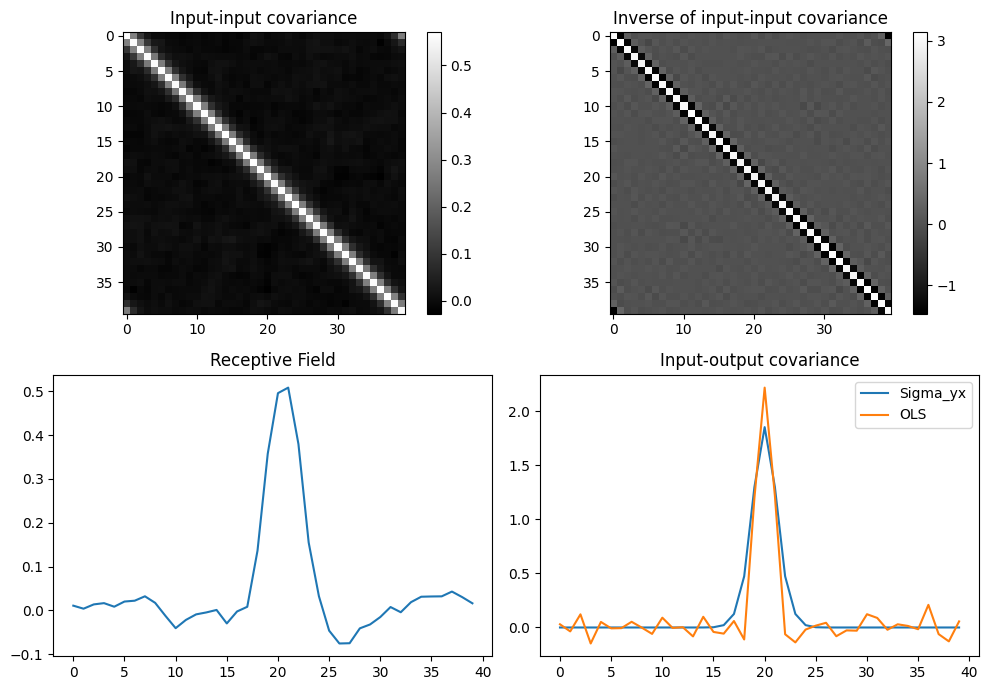

In [104]:
# Mexican hat gate
rf = weights[-1][5]
gate = x @ rf > 0
A = (x[gate].T @ x[gate]) / len(x)
# plot it
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
im = axs[0,0].imshow(A, cmap='gray')
plt.colorbar(im)
axs[0,0].set_title("Input-input covariance")
im = axs[0,1].imshow(np.linalg.inv(A), cmap='gray')
plt.colorbar(im)
axs[0,1].set_title("Inverse of input-input covariance")
axs[1,0].plot(rf)
axs[1,0].set_title("Receptive Field")
axs[1,1].plot(sigma_yx_[-1], label="Sigma_yx")
axs[1,1].plot(np.linalg.inv(A) @ sigma_yx_[-1], label="OLS")
axs[1,1].set_title("Input-output covariance")
axs[1,1].legend()
fig.tight_layout()
fig.savefig('../thoughts/towards_gdln/figs/math/OLS_mexican_hat.png', dpi=300)